In [92]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler, QuantileTransformer
from diagnose import evaluate_forecasts, rolling_forecast_arima, ljungbox_test, durbin_watson_test, change_data, kpss_test, adf_test, zivot_andrews_test



warnings.filterwarnings("ignore")

### CONFIGHERE ###

In [93]:
data_cutoff = -32
figsize=(12, 6)
train_size = 0.80


Projekt ma na celu naukę modelowania szeregów czasowych na danych bez sezonowości poprzez analizę kwartalnych wyników finansowych Amazon (Net Income/Loss). Głównym celem jest porównanie różnych metod prognozowania i wybór najlepszego modelu oraz zastosowania tego modelu w dwóch przykładowych problemach biznesowych.

## 1. Eksploracja Dancych




### Opis danych

Zbiór danych składa się z jednej zmiennej finansowej zawierającej kwartalne obserwacje:

### **Net Income / Loss (wartość liczbowa, dane kwartalne)**  
Zmienna ta przedstawia zysk netto lub stratę netto osiąganą przez przedsiębiorstwo w każdym kwartale. Jest to kluczowy wskaźnik rentowności, wykorzystywany do analizy:

- efektywności finansowej w czasie,
- trendów wzrostu lub spadku wyników,
- sezonowości i cykliczności działalności,
- stabilności finansowej przedsiębiorstwa,
- identyfikacji potencjalnych czynników ryzyka.

Dane mają postać **szeregu czasowego**, w którym wartości są ułożone chronologicznie i występują w równych odstępach czasowych (co kwartał). Dzięki temu zmienna nadaje się do modelowania metodami prognostycznymi, takimi jak ARIMA, SARIMA, modele wygładzania wykładniczego, modele hybrydowe oraz algorytmy uczenia maszynowego.

---


In [94]:
df = pd.read_csv(r'Amazon Net Income by Quarter.csv')


df['Category'] = df['Category'].str.strip()

period_strings = df['Category'].str.replace(r'Q([1-4])\s*(\d{4})', r'\2Q\1', regex=True)

period_idx = pd.PeriodIndex(period_strings, freq='Q')

df.index = period_idx.to_timestamp()           

df.index.name = 'Date'  
real_case_data = df.copy().tail(-data_cutoff)
real_case_data = real_case_data.drop(columns=['Category'])
df = df.head(data_cutoff)
df = df.drop(columns=['Category'])

In [95]:
df.describe()


,Net Income/Loss
count,83.000000
mean,73.662651
std,232.279493
min,-545.000000
25%,-29.000000
50%,73.000000
75%,194.000000
max,857.000000


In [96]:

fig = px.bar(df.reset_index(),
             x='Date',
             y='Net Income/Loss',
             title='Amazon Net Income by Quarter',
             labels={'Net Income/Loss':'Net Income (in Billions)','Date':'Quarter'})

fig.update_traces(marker_color='steelblue', showlegend=False)
fig.update_layout(xaxis_tickformat='%Y-%m', xaxis_tickangle=-45)
fig.show()


## 2. Analiza Dystrybucji

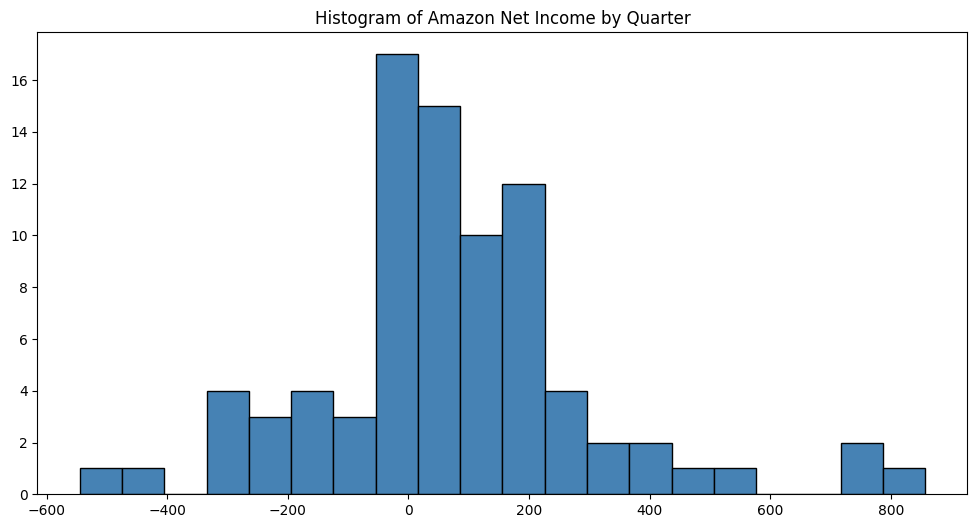

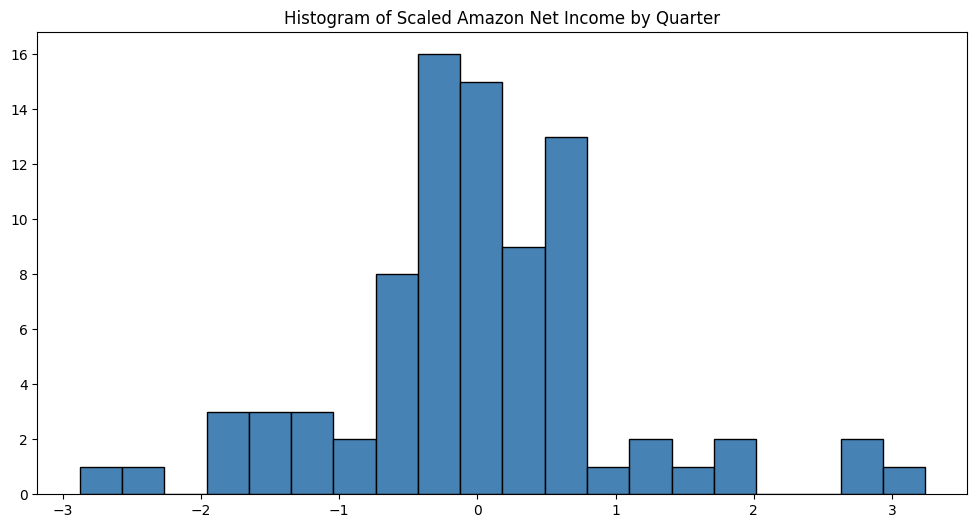

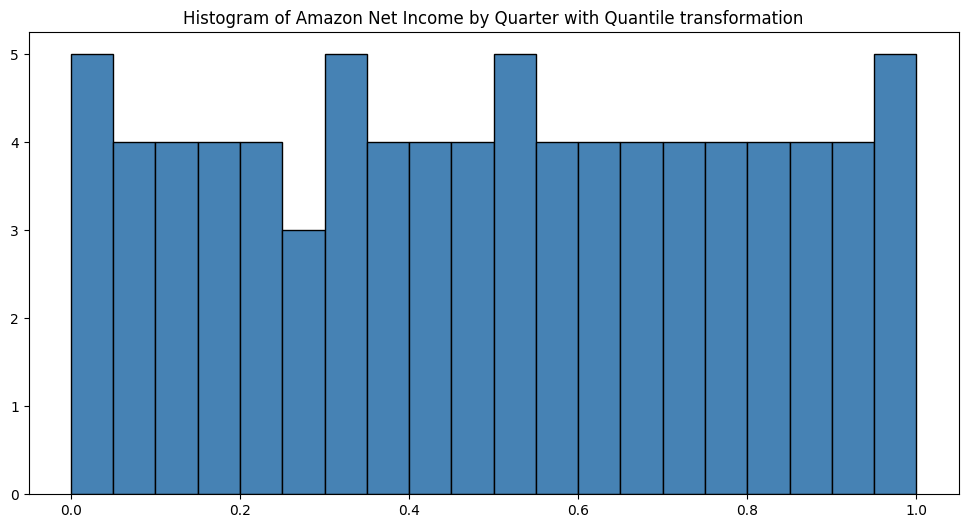

In [97]:

plt.figure(figsize=figsize)
plt.hist(df['Net Income/Loss'], bins=20, color='steelblue', edgecolor='black')
plt.title('Histogram of Amazon Net Income by Quarter')
plt.show()

pt = PowerTransformer(method='yeo-johnson')
scaled_data = pt.fit_transform(df)
plt.figure(figsize=figsize)
plt.hist(scaled_data, bins=20, color='steelblue', edgecolor='black')
plt.title('Histogram of Scaled Amazon Net Income by Quarter')
plt.show()

pt = QuantileTransformer()
scaled_data = pt.fit_transform(df)
plt.figure(figsize=figsize)
plt.hist(scaled_data, bins=20, color='steelblue', edgecolor='black')
plt.title('Histogram of Amazon Net Income by Quarter with Quantile transformation')
plt.show()


## 3. Tesotwanie stacjonarności 


**Szereg czasowy stacjonarny** to taki szereg, którego własności statystyczne pozostają stałe w czasie.  
Oznacza to, że:

- **wartość oczekiwana (średnia)** jest stała,
- **wariancja** jest stała (nie zależy od czasu),
- **kowariancja/autokowariancja** zależy wyłącznie od opóźnienia (lag), a nie od konkretnego momentu czasu.

W praktyce szereg stacjonarny nie wykazuje trendu ani systematycznych zmian zmienności, a jego struktura statystyczna nie zmienia się wraz z upływem czasu.


### Test wizualny - Dekompozycja szeregu czasowego

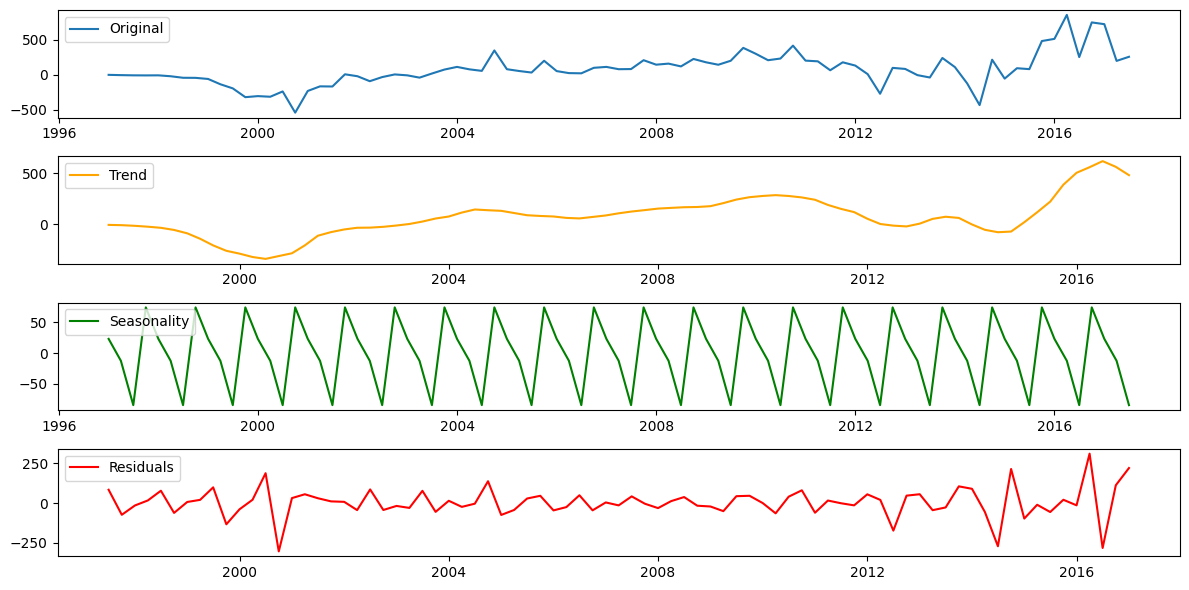

In [98]:
from diagnose import seasonal_decompose_plot
y_basic = df["Net Income/Loss"]

_, _, _ = seasonal_decompose_plot(y_basic, figsize=figsize, plots=True, period=4)

Pierwszy wykres przedstawia przebieg analizowanych danych w czasie. Wizualna inspekcja pozwala na wstępną ocenę, czy szereg jest stacjonarny, czyli czy jego właściwości statystyczne (średnia, wariancja) pozostają stałe w czasie. Na podstawie wykresu można stwierdzić, że dane wykazują niestacjonarność – ich charakterystyka zmienia się wraz z upływem czasu.

Obserwowany trend ma charakter nieliniowy, co oznacza, że zmiany w danych nie następują w sposób jednostajny. Zastosowanie odpowiednich metod usuwania trendu (**detrendingu**) może znacząco poprawić jakość modelu poprzez eliminację systematycznych wzorców i umożliwienie lepszego uchwycenia rzeczywistych zależności w danych, co przełoży się na dokładniejsze prognozy.

Dekompozycja szeregu czasowego wykazuje silną składową sezonową o okresie równym 4, co w przypadku danych kwartalnych odpowiada cyklowi rocznemu.

Analiza reszt modelu ujawnia istotne wartości odstające (outliers), które znacznie przekraczają typową zmienność losową. Obecność takich obserwacji może wskazywać na:

- Zdarzenia jednorazowe lub nietypowe okoliczności
- Strukturalne zmiany w szeregu czasowym
- Potencjalne błędy w danych lub pomiarach

Te anomalie mogą wpływać na jakość dopasowania modelu i dokładność prognoz, jednak w ramach tego projektu zostały pominięte. Dogłębna analiza wartości odstających wymagałaby dodatkowych informacji kontekstowych lub danych pomocniczych, które nie są częścią analizowanego zbioru danych.

### Detrending

Usuwanie trendu zostało przeprowadzone z wykorzystaniem modelu ETS (Error, Trend, Seasonality), który stanowi efektywną metodę stacjonaryzacji danych.

**Zasada działania ETS:**


Model ETS należy do klasy modeli wygładzania wykładniczego i rozdziela szereg czasowy na trzy główne składowe:
- **Error (Błąd)** – składowa losowa reprezentująca nieprzewidywalne wahania
- **Trend** – długoterminowa tendencja wzrostowa lub spadkowa w danych
- **Seasonality (Sezonowość)** – regularne, powtarzające się wzorce (SEZONOWOŚĆ w naszym przypadku jest pomijana)

Kluczową zaletą metody ETS jest jej elastyczność – każda składowa może przyjmować różne formy (addytywną, multiplikatywną lub brak, w naszym przypadku wybrano addytywną), co pozwala na dopasowanie modelu do specyfiki danych. Model automatycznie dobiera optymalne wagi dla poszczególnych składowych, przypisując większe znaczenie nowszym obserwacjom poprzez mechanizm wygładzania wykładniczego.

Po estymacji parametrów, model ETS pozwala na wyizolowanie składowej trendu, która następnie może zostać usunięta z oryginalnego szeregu, co prowadzi do uzyskania danych odtrendowanych, bardziej stabilnych statystycznie.

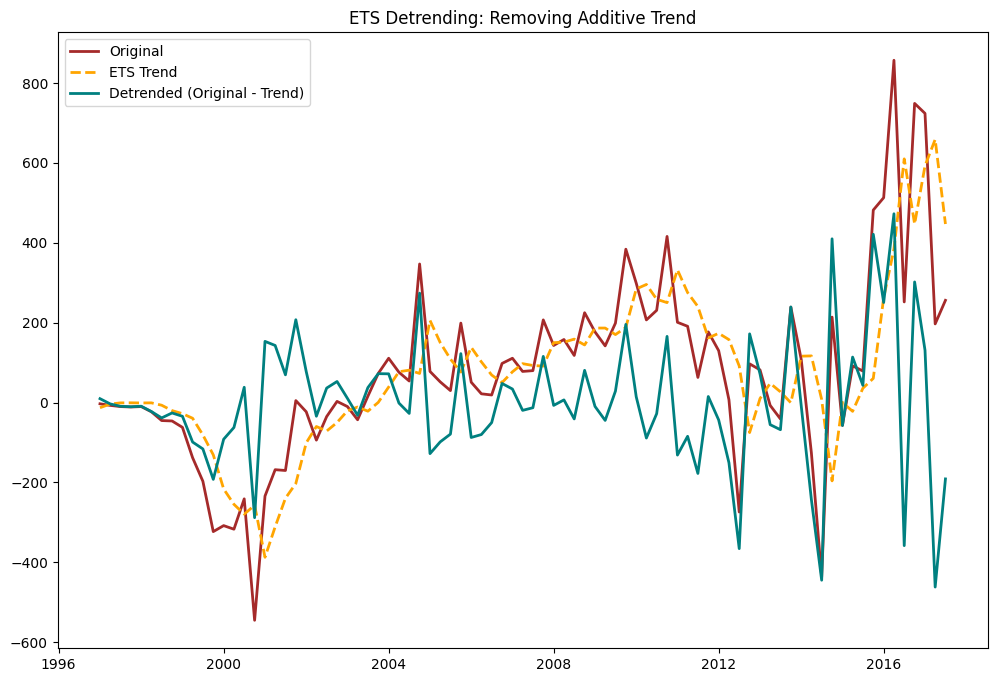

Original std:   230.8760
Detrended std:  163.8208


In [99]:
from diagnose import detrending

y_d = df["Net Income/Loss"].copy()

y_detrended = detrending(y_d.values, y_d.index, plots=True)

Niebieski wykres przedstawia dane po usunięciu trendu. Ponowna wizualna inspekcja wskazuje na poprawę – szereg wygląda bardziej stabilnie, jednak nadal nie wykazuje pełnej stacjonarności na całej długości analizowanego okresu.

### Testy Statystyczne

W praktyce produkcyjnej rzadko stosuje się wizualne metody weryfikacji stacjonarności, ponieważ przy dużej liczbie modeli analityk nie jest w stanie przejrzeć wszystkich wykresów. Testy statystyczne nadają się natomiast doskonale do automatyzacji procesu trenowania modeli.

Wykonamy 3 testy statystyczne na danych bazowych i po odjęciu trendu
- KPSS test 
- ADF test (Augmented Dickey-Fuller)
- Zivot-Andrews test

Te testy mają swoje wady:
KPSS
- Często prowadzi to do sprzecznych wyników z ADF
- Test KPSS łatwo „fałszywie odrzuca” stacjonarność, jeśli wariancja nie jest stała
- Zbyt mały lag prowadzi często do fałszywego wykrycia niestacjonarności.

ADF
- Niska moc testu, szczególnie gdy proces jest blisko niestacjonarności (unit root bliski 1)
- Jeśli w szeregu jest zmiana trendu źle sobie radzi 
- Zakłada liniowość

Zivot-Andrews
- Nie obsługuje sezonowości
- Nie obsługuje heteroskedastyczności
- Słaba moc testu dla małej ilości danych 

Aby ograniczyć wpływ ograniczeń i słabej mocy pojedynczych testów stacjonarności, stosuje się duality testing – podejście polegające na równoczesnym wykorzystaniu dwóch testów o przeciwnych hipotezach zerowych, najczęściej ADF oraz KPSS. Ponieważ jeden test zakłada w hipotezie zerowej niestacjonarność, a drugi stacjonarność, ich wspólne wyniki pozwalają uzyskać znacznie bardziej wiarygodną ocenę charakteru szeregu czasowego. Dzięki temu możliwe jest lepsze wychwycenie sytuacji, w których pojedynczy test byłby mylący, np. z powodu zmian strukturalnych, autokorelacji czy bliskości pierwiastka jednostkowego.

In [100]:
from diagnose import diagnose_stationarity

diagnose_stationarity(df["Net Income/Loss"])


KPSS Statistic: 0.7080151181246679
p-value: 0.01281680744321201
Critical Values:
Conclusion: Non-stationary


==== Augmented Dickey-Fuller Test ====
ADF Statistic : -1.0973578021738752
p-value       : 0.7161244320889657
Conclusion: Non-stationary


==== Zivot–Andrews Test (structural break) ====
Test Statistic : -3.797107816874387
p-value        : 0.4809566395150746
Conclusion: Non-stationary




Wszystkie testy wykazują niestacjonarność danych bazowych.


In [101]:

diagnose_stationarity(y_detrended)

KPSS Statistic: 0.06654101175659757
p-value: 0.1
Critical Values:
Conclusion: Stationary


==== Augmented Dickey-Fuller Test ====
ADF Statistic : -3.1689764434497434
p-value       : 0.021852150624549576
Conclusion: Stationary


==== Zivot–Andrews Test (structural break) ====
Test Statistic : -4.36365613324368
p-value        : 0.16578272361140264
Conclusion: Non-stationary




2 na 3 testy wykazują stacjonarność. Tu decyzja zależy od analityka, dwa wyniki testów o przeciwnych hipotezach ADF i KPSS można potraktowac jako wystarczająca pewność stacjonarności. W naszym przypadku będziemy oczekiwać przejścia wszystkich testów.

### Różnicowanie
Różnicowanie jest jedną z metod detrendingu, jednak w przeciwieństwie do innych technik usuwania trendu może w wyraźny sposób zmieniać strukturę informacji zawartych w danych. Już po jednokrotnym różnicowaniu tracimy pierwszą obserwację szeregu, ponieważ nie da się obliczyć różnicy dla punktu, który nie ma poprzednika. Można co prawda odtworzyć tę wartość, sztucznie ją dodając, jednak często prowadzi to do powstania wartości odstającej. Taki sztucznie odzyskany punkt może zaburzać rozkład danych i negatywnie wpływać na jakość estymacji oraz wyniki modelu.

In [102]:
diagnose_stationarity(df["Net Income/Loss"].diff().dropna())

KPSS Statistic: 0.08990827868460187
p-value: 0.1
Critical Values:
Conclusion: Stationary


==== Augmented Dickey-Fuller Test ====
ADF Statistic : -5.298350769866576
p-value       : 5.518890115735547e-06
Conclusion: Stationary


==== Zivot–Andrews Test (structural break) ====
Test Statistic : -6.285800616828147
p-value        : 0.0005282500675486978
Conclusion: Stationary






In [103]:
diagnose_stationarity(y_detrended.diff().dropna())

KPSS Statistic: 0.34326300973025
p-value: 0.1
Critical Values:
Conclusion: Stationary


==== Augmented Dickey-Fuller Test ====
ADF Statistic : -5.904112602058355
p-value       : 2.7341810683367495e-07
Conclusion: Stationary


==== Zivot–Andrews Test (structural break) ====
Test Statistic : -6.272152400843527
p-value        : 0.0005424356148712945
Conclusion: Stationary






Zastosownia obydwóch metod usuwania trendu przechodzi przez wszystkie 3 testy statystyczne dla obu zestawów danych.

**Wniosek:**  
Na podstawie wyników testów stacjonarności można stwierdzić, że zastosowanie pierwszego różnicowania (**d = 1**) jest odpowiednie dla analizowanych szeregow czasowych w modelu ARIMA.  
Pierwsze różnicowanie skutecznie eliminuje niestacjonarność, stabilizując średnią i umożliwiając poprawne modelowanie procesów autoregresyjnych.


## 4. Wybór optymalnych parametrów modelu ARIMA




In [104]:
train = df["Net Income/Loss"][:int(len(df) * train_size)]
test = df["Net Income/Loss"][int(len(df) * train_size):]

method = ["none", "detrending", "scaling", "standard scaling", "quantile scaling"]


W celu identyfikacji najlepszej konfiguracji modelu ARIMA przeprowadzono **Grid Search** w przestrzeni parametrów:

- **p** – rząd składnika autoregresyjnego (AR): **1–4**
- **d** – rząd różnicowania: **0–1**
- **q** – rząd składnika średniej ruchomej (MA): **1–4**

**Kryterium wyboru modelu:**  
**AIC (Akaike Information Criterion)** — im niższa wartość, tym lepsze dopasowanie modelu przy jednoczesnym zachowaniu prostoty.

In [105]:
results = []
max_p = 4
max_d = 1
max_q = 4

for meth in method:          
    data = train.copy()

    for p in range(1, max_p+1):
        for d in range(0, max_d+1):
            for q in range(0, max_q+1):
                order = (p, d, q)

                try:
                    data_transformed = change_data(data, method=meth)
                    model = ARIMA(data_transformed, order=order,
                        enforce_invertibility=False, enforce_stationarity=False)
                    model_fit = model.fit()

                    results.append({
                        "method": meth,
                        "p,d,q": order,
                        "AIC": model_fit.aic,
                        "BIC": model_fit.bic
                    })

                except:
                    continue

results_df = pd.DataFrame(results)

print("====== BEST AIC ORDER BY METHOD ======")
order_list = []


for meth in results_df["method"].unique():

    sub = results_df[results_df["method"] == meth]

    if sub.empty:
        print(f"Method: {meth}")
        print("  ❌ No valid ARIMA models for this method.")
        print("----------------------------------")
        continue

    best_row = sub.sort_values("AIC").iloc[0]

    print(f"Method: {meth}")
    print(f"  Best order: {best_row['p,d,q']}")
    print(f"  AIC: {best_row['AIC']}")
    print("----------------------------------")
    order_list.append(best_row['p,d,q'])

optimized_orders = {
    "method": method,
    "best_orders": order_list
}

====== BEST AIC ORDER BY METHOD ======
Method: none
  Best order: (3, 1, 4)
  AIC: 737.5384787253156
----------------------------------
Method: detrending
  Best order: (3, 1, 4)
  AIC: 737.5384787253156
----------------------------------
Method: scaling
  Best order: (3, 1, 3)
  AIC: 112.50242598517865
----------------------------------
Method: standard scaling
  Best order: (3, 1, 4)
  AIC: 737.5384787253156
----------------------------------
Method: quantile scaling
  Best order: (3, 1, 4)
  AIC: 737.5384787253156
----------------------------------


## 5. Sprawdzanie założeń modelu ARIMA

### Założenia modelu ARIMA

Model **ARIMA** (Autoregressive Integrated Moving Average) jest jednym z najczęściej stosowanych modeli do analizy i prognozowania szeregów czasowych. Jego poprawne zastosowanie opiera się na kilku kluczowych założeniach:

### 1. Stacjonarność
- Szereg czasowy powinien być **stacjonarny** – jego statystyki (średnia, wariancja, autokorelacja) nie zmieniają się w czasie.  
- Jeśli szereg nie jest stacjonarny, stosuje się **różnicowanie (d)**, aby osiągnąć stacjonarność.

### 2. liniowa zależność
- ARIMA zakłada, że obecna wartość szeregu może być opisana jako **liniowa kombinacja** wcześniejszych wartości (AR) i wcześniejszych reszt (MA).  
- Nieliniowe zależności mogą wymagać innych modeli (np. ARCH, GARCH, LSTM).

### 3. Brak sezonowości (w standardowej ARIMA)
- Standardowy model ARIMA nie uwzględnia sezonowości.  
- Dla danych sezonowych stosuje się model **SARIMA**, który dodaje komponent sezonowy.

### 4. Niezależność reszt (szum biały)
- Reszty modelu powinny być **niezależne i losowe** (szum biały).  
- Jeśli reszty wykazują autokorelację, oznacza to, że model nie uchwycił wszystkich istotnych zależności.

### 5. Normalność rozkładu reszt
- ARIMA zakłada, że reszty mają **rozkład normalny**, co jest szczególnie istotne przy estymacji przedziałów ufności prognoz.

---

**Podsumowanie:**  
Model ARIMA jest efektywny dla szeregu stacjonarnego o liniowych zależnościach, z niezależnym szumem. Przed zastosowaniem modelu często konieczne jest różnicowanie i weryfikacja autokorelacji oraz stabilności wariancji.


Ljung-Box Test (lags = [10]):
Lag 10: LB Statistic = 3.2480, p-value = 0.9750
   Conclusion: No significant autocorrelation (Random)


Durbin-Watson Statistic: 1.9611
Conclusion: No significant autocorrelation




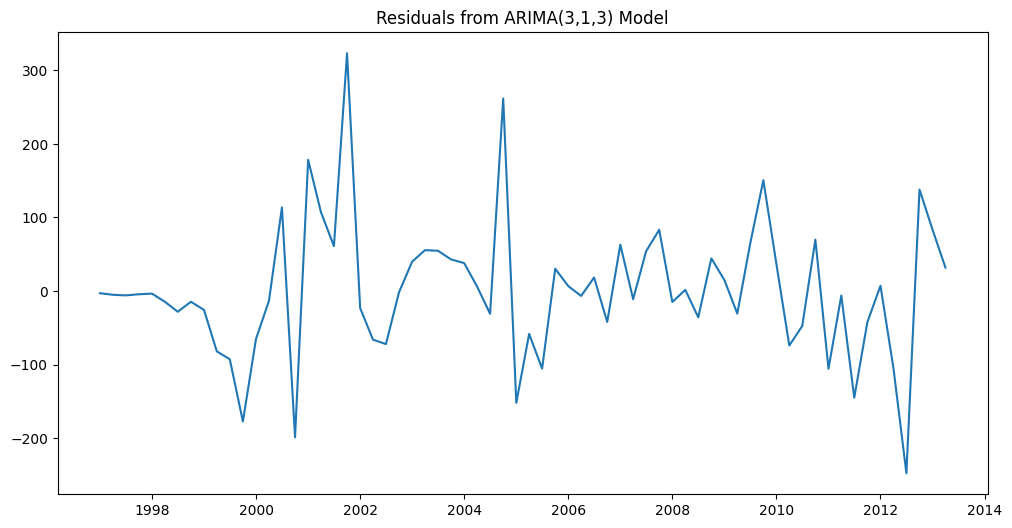

In [106]:
arimka = ARIMA(train, order=optimized_orders["best_orders"][0], enforce_invertibility=False, enforce_stationarity=False)
arimka = arimka.fit()

residuals = arimka.resid

ljungbox_test(residuals, lags=[10])
durbin_watson_test(residuals)

plt.figure(figsize=figsize)
plt.plot(residuals)
plt.title('Residuals from ARIMA(3,1,3) Model')
plt.show()

## 6. Walidacja Arcitektury Modelu

W celu oceny jakości prognoz modelu ARIMA zastosowano walidację krzyżową dostosowaną do danych szeregów czasowych. Dane zostały podzielone sekwencyjnie na trzy równe części, z zachowaniem chronologii obserwacji. Model był estymowany na wcześniejszym fragmencie danych, a następnie testowany na kolejnych częściach zbioru. Jako miarę jakości prognoz wykorzystano średni błąd bezwzględny (MAE).



Cross-walidacja pozwala ocenić, jak model ARIMA radzi sobie z prognozowaniem niewidzianych wcześniej danych, a nie tylko z dopasowaniem do próby uczącej.

Walidacja na kolejnych odcinkach czasowych umożliwia sprawdzenie, czy model zachowuje stabilność parametrów i jakości prognoz w różnych okresach szeregu.

In [107]:
from sklearn.model_selection import TimeSeriesSplit


data = train

n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

mae_scores = []

for train_index, test_index in tscv.split(data):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

    model = ARIMA(train_data, order=optimized_orders["best_orders"][0])  
    fitted_model = model.fit()

    predictions = fitted_model.forecast(steps=len(test_data))

    mae = np.abs(test_data - predictions).mean()
    mae_scores.append(mae)

    print(f'Mean Absolute Error for current split: {mae}')

average_mse = np.mean(mae_scores)
print(f'Sredni błąd absolutny: {average_mse}')
print(f"Odchylenie standardowe MAE: {np.std(mae_scores)}")

Mean Absolute Error for current split: 195.75004579607548
Mean Absolute Error for current split: 62.47951301896531
Mean Absolute Error for current split: 116.01410621977604
Sredni błąd absolutny: 124.74788834493893
Odchylenie standardowe MAE: 54.756843951729365


## 7. Predykcja

Naiwna predykcja oparta na modelu ekstrapolowanym na dużą liczbę okresów w przód często okazuje się niskiej jakości. Założenia spełnione poprzez odpowiednie przekształcenia danych zapewniają stabilność modelu jedynie dla obserwacji historycznych. Nie istnieje natomiast żadna gwarancja, że te same własności będą zachowane dla danych przyszłych, co może prowadzić do pogorszenia jakości prognoz

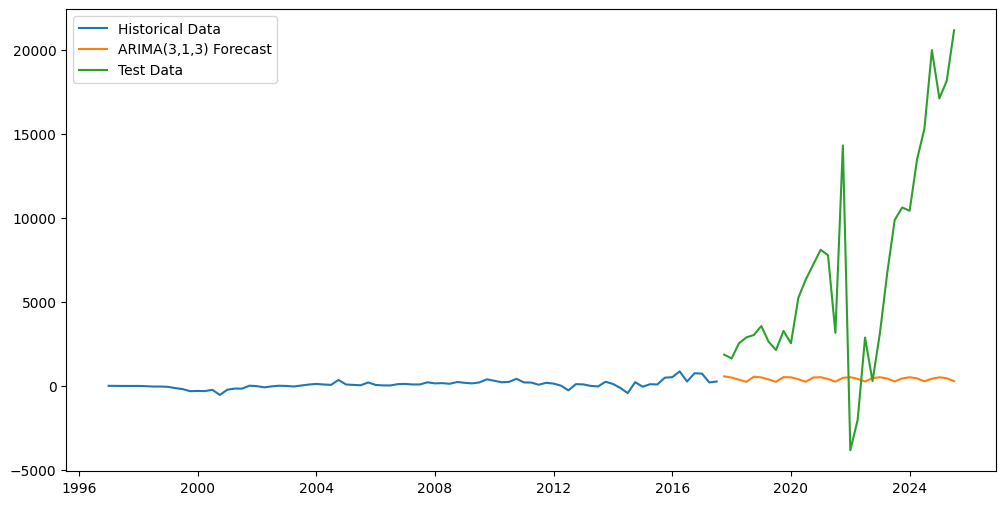

In [108]:
arimka = ARIMA(df["Net Income/Loss"], order=optimized_orders["best_orders"][0])

arimka = arimka.fit()
arimka_pred = arimka.forecast(-data_cutoff)

plt.figure(figsize=figsize)
plt.plot(df, label='Historical Data')
plt.plot(arimka_pred, label='ARIMA(3,1,3) Forecast')
plt.plot(real_case_data.tail(-data_cutoff), label='Test Data')
plt.legend()
plt.show()


Jednym ze sposobów przeciwdziałania temu zjawisku jest bieżąca aktualizacja modeli po napływie nowych danych. W takiej sytuacji może się okazać, że inny zestaw parametrów modelu lepiej opisuje aktualną strukturę danych, co prowadzi do poprawy jakości prognoz.

In [109]:
optimized_orders

{'method': ['none',
  'detrending',
  'scaling',
  'standard scaling',
  'quantile scaling'],
 'best_orders': [(3, 1, 4), (3, 1, 4), (3, 1, 3), (3, 1, 4), (3, 1, 4)]}

In [110]:
predictions = []
metrics_arima = []
fitted_values_arima = []
for i in range(len(optimized_orders["best_orders"])): 
    pred, met, fitted = rolling_forecast_arima(
        df["Net Income/Loss"], 
        order=optimized_orders["best_orders"][i], 
        method=optimized_orders["method"][i],  
        start_frac=train_size
    )
    predictions.append(pred)
    metrics_arima.append(met)
    fitted_values_arima.append(fitted)


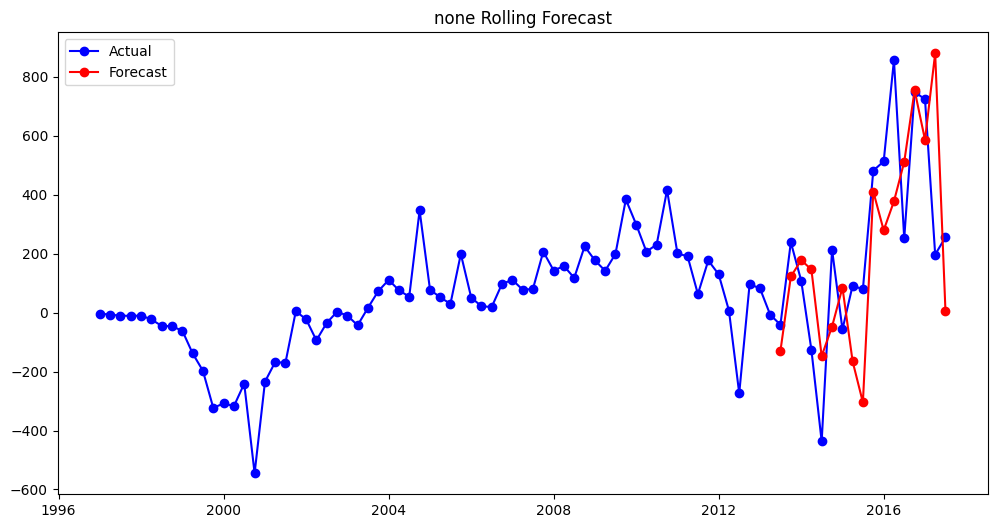

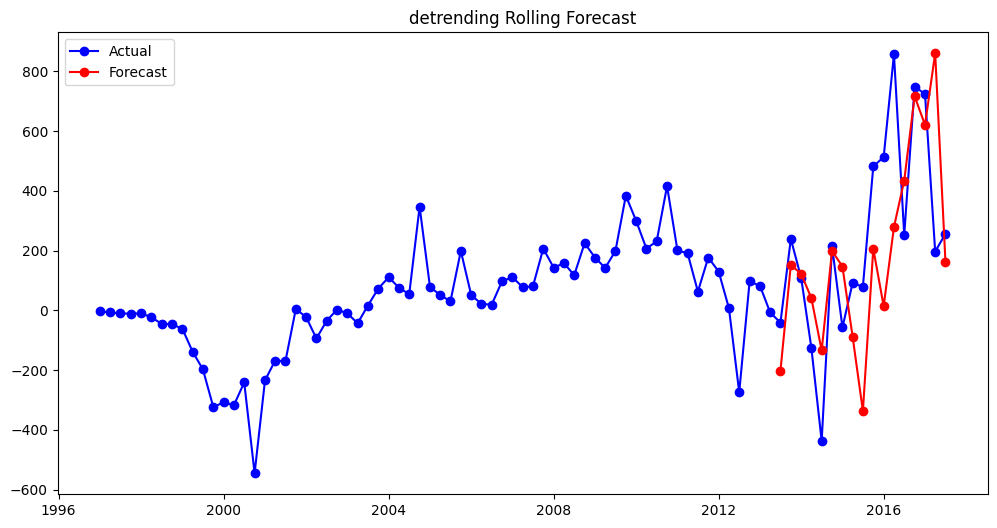

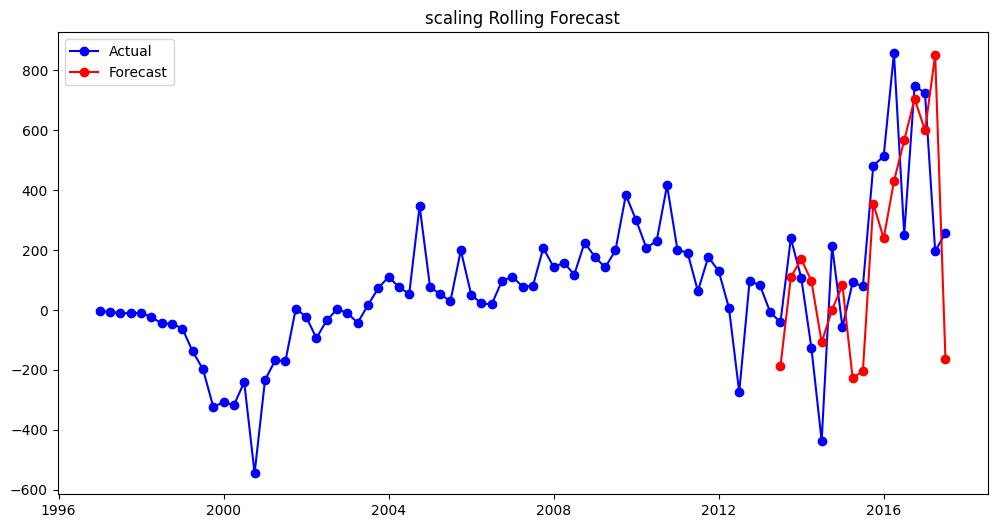

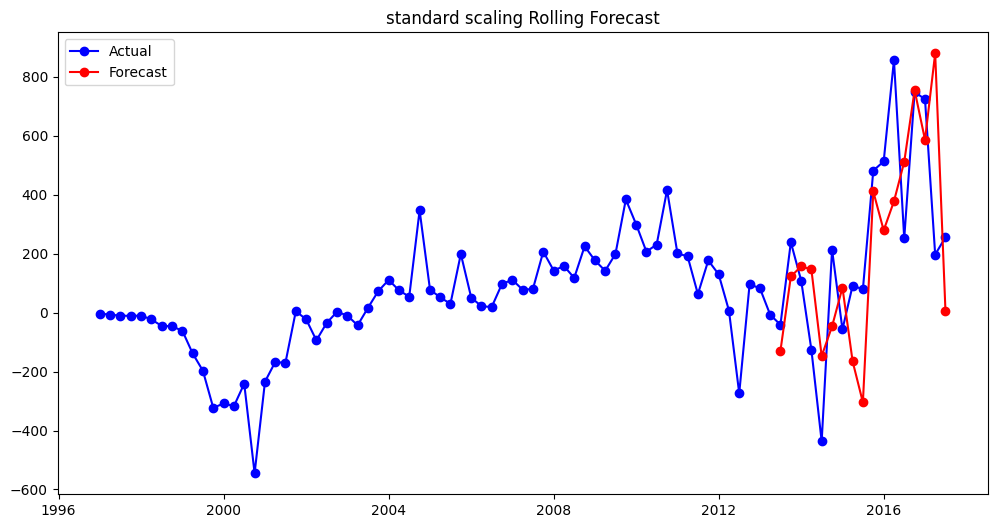

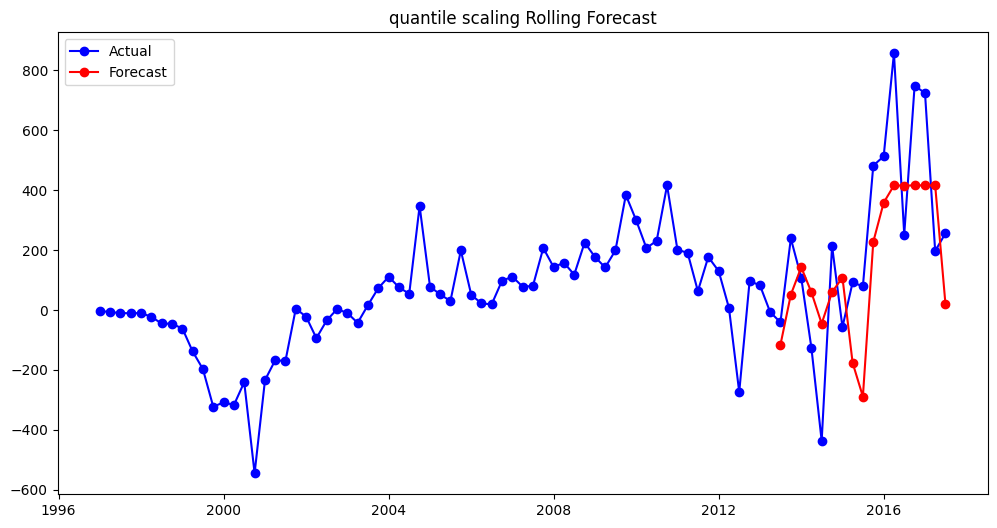

In [111]:
for i in range(len(method)):
    plt.figure(figsize=figsize)
    plt.plot(df["Net Income/Loss"], label='Actual',  marker='o', color="blue")
    plt.plot(predictions[i]["forecast"], label='Forecast',  marker='o', color="red")
    plt.legend()
    plt.title(f"{method[i]} Rolling Forecast")
    plt.show()


W każdym kroku estymacji model oparty jest na 
𝑛
n ostatnich obserwacjach i służy wyłącznie do prognozowania następnego okresu. Po uzyskaniu nowej obserwacji jest ona dołączana do zbioru danych, a model podlega ponownej estymacji.

Następnie zbudujemy wiele wariantów modelu, a ostatecznego wyboru dokonamy na podstawie wartości wybranych metryk jakości prognoz.

## Prophet

## Architektura modelu Prophet

Model **Prophet** (Facebook/Meta Prophet) to elastyczny model prognostyczny oparty na addytywnej dekompozycji czasowej. Został zaprojektowany z myślą o wysokiej interpretowalności oraz odporności na typowe wyzwania w danych czasowych, takie jak sezonowość, zmiany trendu czy nieregularne obserwacje.

Struktura addytywna

Prophet modeluje serię czasową jako sumę trzech głównych komponentów:

y(t) = g(t) + s(t) + h(t) + ε(t)

gdzie:  
- **g(t)** – komponent trendu,  
- **s(t)** – komponent sezonowości,  
- **h(t)** – wpływ dni świątecznych i zdarzeń specjalnych,  
- **ε(t)** – składnik losowy (szum).

---

In [112]:
from prophet import Prophet
from sklearn.preprocessing import StandardScaler

df_clean = df.copy()
df_clean = df_clean.reset_index().rename(columns={'Date': 'ds', 'Net Income/Loss': 'y'})

freq = pd.infer_freq(df_clean['ds'])
if freq is None:
    raise ValueError("Cannot infer datetime frequency from your data.")

start_index = int(train_size * len(df_clean))
train_prophet = df_clean.iloc[:start_index].copy()
test_prophet = df_clean.iloc[start_index:].copy()

scaler = StandardScaler()
train_prophet['y'] = scaler.fit_transform(train_prophet[['y']])
test_scaled_y = scaler.transform(test_prophet[['y']])

history = train_prophet.copy()
pred_scaled = []

for t in range(len(test_prophet)):
    model = Prophet(
        daily_seasonality='auto',
        weekly_seasonality='auto',
        yearly_seasonality='auto',
        n_changepoints = 20
    )
    model.fit(history)

    future = model.make_future_dataframe(periods=1, freq=freq)
    forecast = model.predict(future)

    yhat = forecast['yhat'].iloc[-1]
    pred_scaled.append(yhat)

    new_row = test_prophet.iloc[[t]].copy()
    new_row['y'] = test_scaled_y[t][0]
    history = pd.concat([history, new_row], ignore_index=True)

predictions_prohpet = scaler.inverse_transform(np.array(pred_scaled).reshape(-1, 1))
true_values = df_clean['y'].iloc[start_index:].values



20:34:25 - cmdstanpy - INFO - Chain [1] start processing
20:34:25 - cmdstanpy - INFO - Chain [1] done processing
20:34:25 - cmdstanpy - INFO - Chain [1] start processing
20:34:26 - cmdstanpy - INFO - Chain [1] done processing
20:34:26 - cmdstanpy - INFO - Chain [1] start processing
20:34:26 - cmdstanpy - INFO - Chain [1] done processing
20:34:26 - cmdstanpy - INFO - Chain [1] start processing
20:34:26 - cmdstanpy - INFO - Chain [1] done processing
20:34:26 - cmdstanpy - INFO - Chain [1] start processing
20:34:27 - cmdstanpy - INFO - Chain [1] done processing
20:34:27 - cmdstanpy - INFO - Chain [1] start processing
20:34:27 - cmdstanpy - INFO - Chain [1] done processing
20:34:27 - cmdstanpy - INFO - Chain [1] start processing
20:34:27 - cmdstanpy - INFO - Chain [1] done processing
20:34:27 - cmdstanpy - INFO - Chain [1] start processing
20:34:28 - cmdstanpy - INFO - Chain [1] done processing
20:34:28 - cmdstanpy - INFO - Chain [1] start processing
20:34:28 - cmdstanpy - INFO - Chain [1]

In [113]:
len(train_prophet) == len(train)
len(test_prophet) == len(test)

True

In [114]:
test_prophet_values = pd.Series(test_prophet["y"].tolist())
pr_metrics = evaluate_forecasts(test_prophet_values, np.array(predictions_prohpet).flatten())

MAE: 242.025088948144
RMSE: 317.9059835589289
sMAPE (%): 93.61485170185829
MASE: 0.8641071492718824
R² Score: 0.06356894778148536


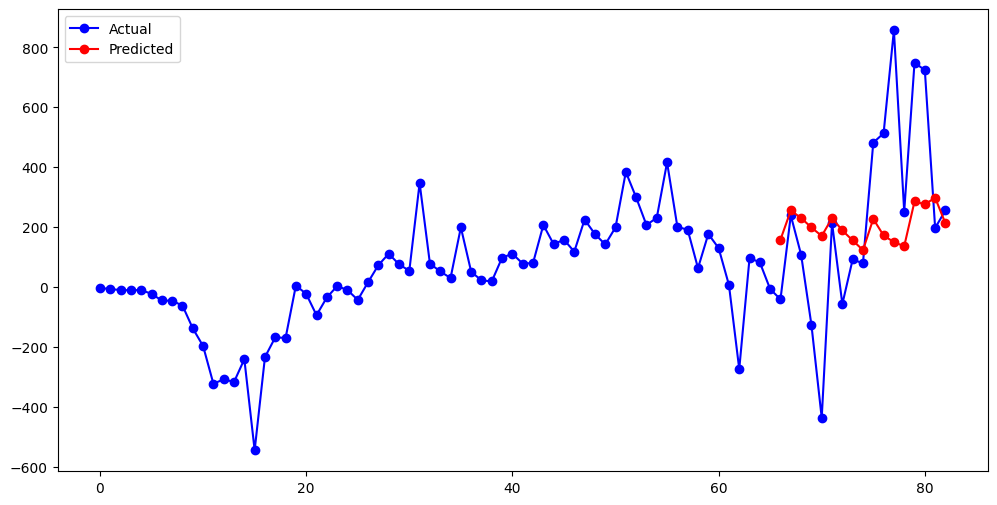

In [115]:

plt.figure(figsize=figsize)
plt.plot(df["Net Income/Loss"].values, marker="o", label="Actual", color="blue")
plt.plot(test_prophet.index, predictions_prohpet, color='red', marker="o", label='Predicted')
plt.legend()
plt.show()

## Exponential Smoothing


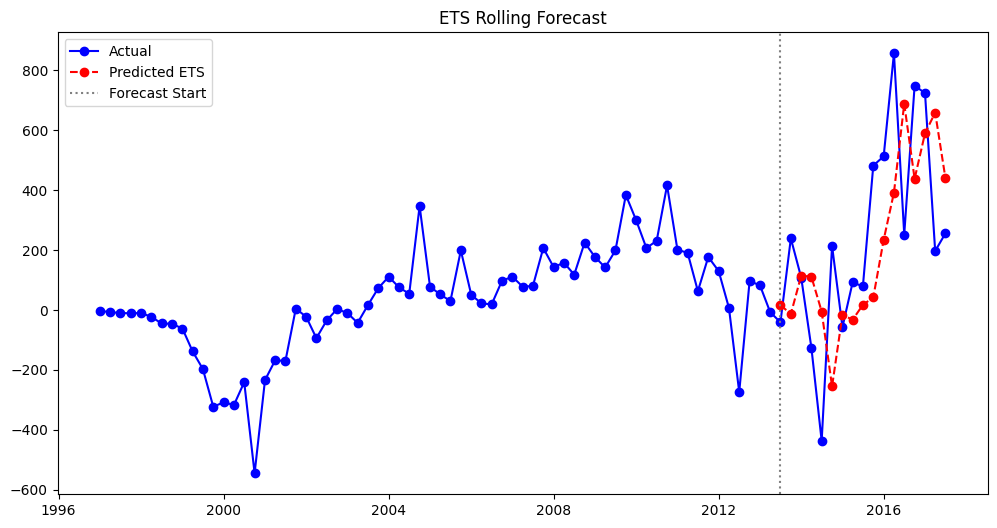

MAE: 258.3928534861323
RMSE: 305.8712792198071
sMAPE (%): 122.67557775672596
MASE: 0.956765473231491
R² Score: 0.133126352215581


In [116]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

series = pd.Series(df.values.flatten(), index=df.index)

train_ets = series.iloc[:start_index]
test_ets = series.iloc[start_index:]

test_ets = pd.Series(test_ets, index=series.index[start_index:])

history = train_ets.copy()
pred_ets = []

for t in range(len(test_ets)):
    model = ExponentialSmoothing(history, trend=None, seasonal=None)  # brak sezonowości
    model_fit = model.fit(optimized=True)
    
    yhat = model_fit.forecast(1)[0]
    pred_ets.append(yhat)
    
    new_point = pd.Series([test_ets.iloc[t]], index=[test_ets.index[t]])
    history = pd.concat([history, new_point])


plt.figure(figsize=figsize)
plt.plot(series, label='Actual',  marker='o', color = "blue")
plt.plot(test_ets.index, pred_ets, color='red', linestyle='--', label='Predicted ETS',  marker='o')
plt.axvline(series.index[start_index], color='gray', linestyle=':', label='Forecast Start')
plt.legend()
plt.title("ETS Rolling Forecast")
plt.show()

ETS_metrics = evaluate_forecasts(test_ets, pred_ets)

## Ensemble Model

### Średnia modeli

MAE: 236.45563188311215
RMSE: 272.6960958154436
sMAPE (%): 111.01218455478391
MASE: 0.862423880186208
R² Score: 0.3109729965178639


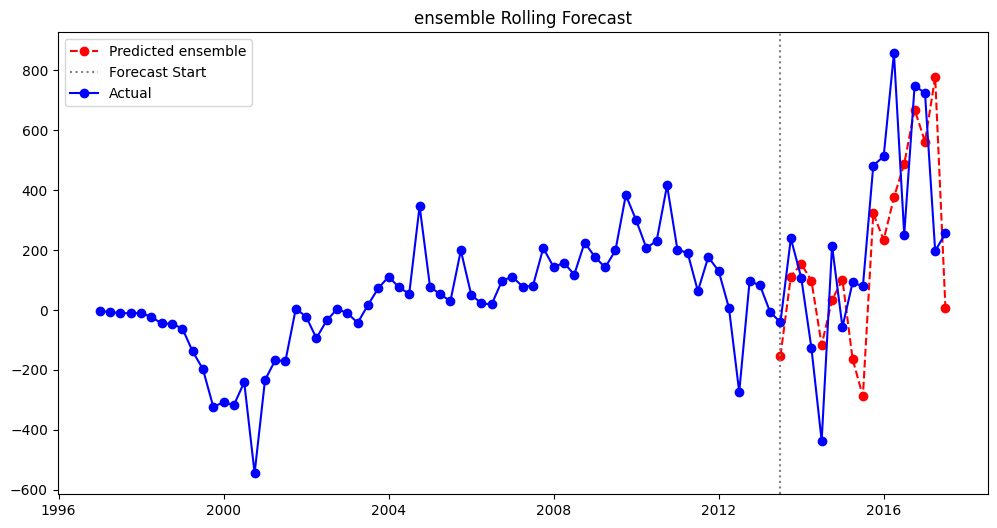

In [117]:
forecast_dfs = pd.DataFrame({
    method[i]: predictions[i]["forecast"] for i in range(len(method))
}, index=predictions[0].index)

ensemble_prediction = forecast_dfs.mean(axis=1)

enseblme_metrics = evaluate_forecasts(test, ensemble_prediction)


plt.figure(figsize=figsize)
plt.plot(test_ets.index, ensemble_prediction, color='red', linestyle='--', label='Predicted ensemble',  marker='o')
plt.axvline(series.index[start_index], color='gray', linestyle=':', label='Forecast Start')
plt.plot(df["Net Income/Loss"], color = "blue", label="Actual", marker="o")

plt.legend()
plt.title("ensemble Rolling Forecast")
plt.show()


### Średnia Ważona modeli


MAE: 238.32346494013257
RMSE: 288.22215688204966
sMAPE (%): 106.42027313219306
MASE: 0.8619037387249823
R² Score: 0.2302793642833768


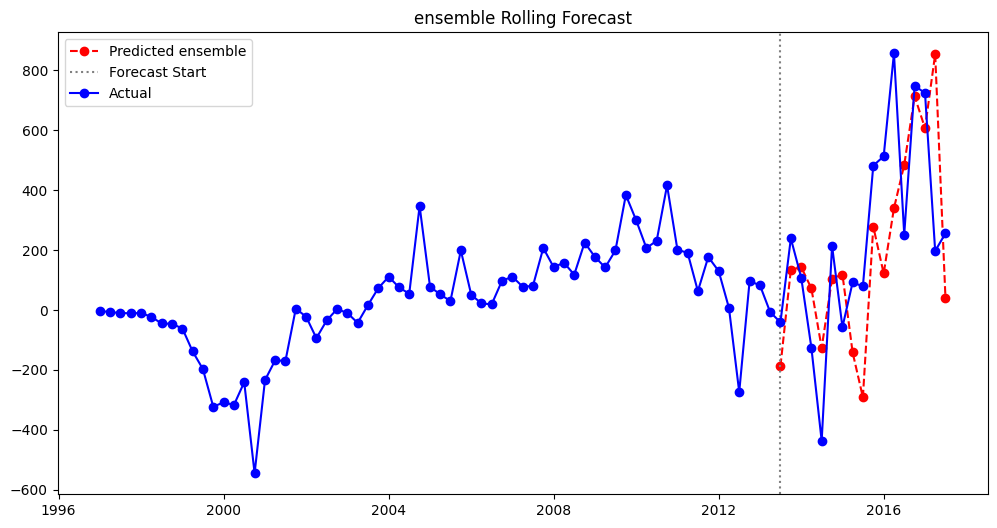

In [118]:
arr = np.random.rand(5)
weights = arr / arr.sum()

weighted_ensemble_prediction = (forecast_dfs * weights).sum(axis=1)

weighted_enseblme_metrics = evaluate_forecasts(test, weighted_ensemble_prediction)


plt.figure(figsize=figsize)
plt.plot(test_ets.index, weighted_ensemble_prediction, color='red', linestyle='--', label='Predicted ensemble',  marker='o')
plt.axvline(series.index[start_index], color='gray', linestyle=':', label='Forecast Start')
plt.plot(df["Net Income/Loss"], color = "blue", label="Actual", marker="o")

plt.legend()
plt.title("ensemble Rolling Forecast")
plt.show()


## XGBoost model

In [119]:
fitted_values_dataframe = pd.DataFrame({
    method[i]: fitted_values_arima[i] for i in range(len(method))
})


In [120]:
from xgboost import XGBRegressor

lags = 3
start_index = int(len(df) * train_size)

series = pd.Series(df.values.flatten(), index=df.index)
train_series = series.iloc[:start_index]
test_series = series.iloc[start_index:]

history = train_series.copy()
pred_xgb = []

for t in range(len(test_series)):
    if len(history) <= lags:
        X_train = np.array([history.values[-lags:]])
        y_train = np.array([history.values[-1]])
        yhat = history.values[-1]
    else:
        X_train = []
        y_train = []
        for i in range(lags, len(history)):
            X_train.append(history.values[i-lags:i])
            y_train.append(history.values[i])
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        model = XGBRegressor()
        model.fit(X_train, y_train)

        last_lags = history.values[-lags:]
        yhat = model.predict(last_lags.reshape(1, -1))[0]

    pred_xgb.append(yhat)

    history = pd.concat([history, pd.Series([test_series.iloc[t]], index=[test_series.index[t]])])

XGB_metrics = evaluate_forecasts(test, pred_xgb)


MAE: 263.91100743237666
RMSE: 324.82708985961403
sMAPE (%): 111.82509878644625
MASE: 0.9748539393165468
R² Score: 0.022351170337667536


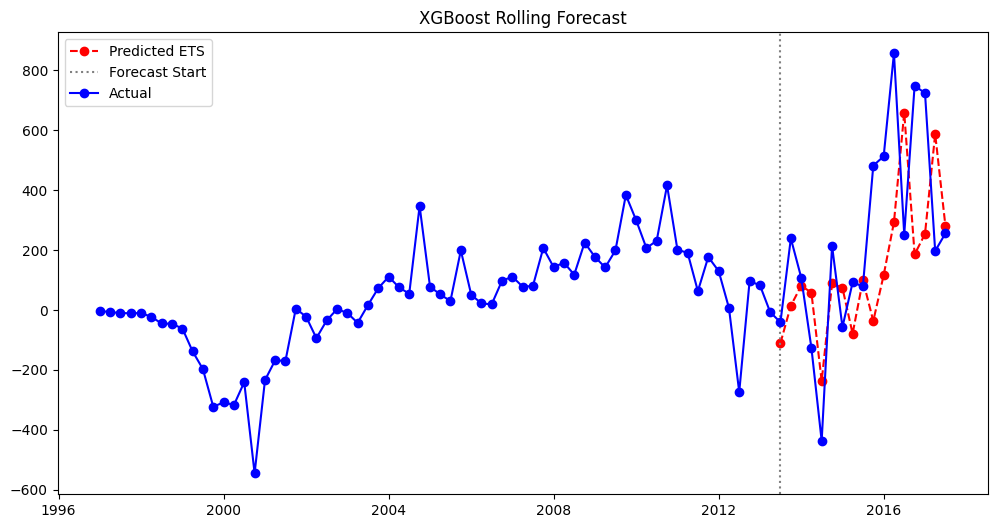

In [121]:
plt.figure(figsize=figsize)
plt.plot(test_ets.index, pred_xgb, color='red', linestyle='--', label='Predicted',  marker='o')
plt.axvline(series.index[start_index], color='gray', linestyle=':', label='Forecast Start')
plt.plot(df["Net Income/Loss"], color = "blue", label="Actual", marker="o")

plt.legend()
plt.title("XGBoost Rolling Forecast")
plt.show()

## Model na resztach

MAE: 296.135306195756
RMSE: 373.8159499773715
sMAPE (%): 152.79777923765602
MASE: 1.0890139423614202
R² Score: -0.2947742627165235


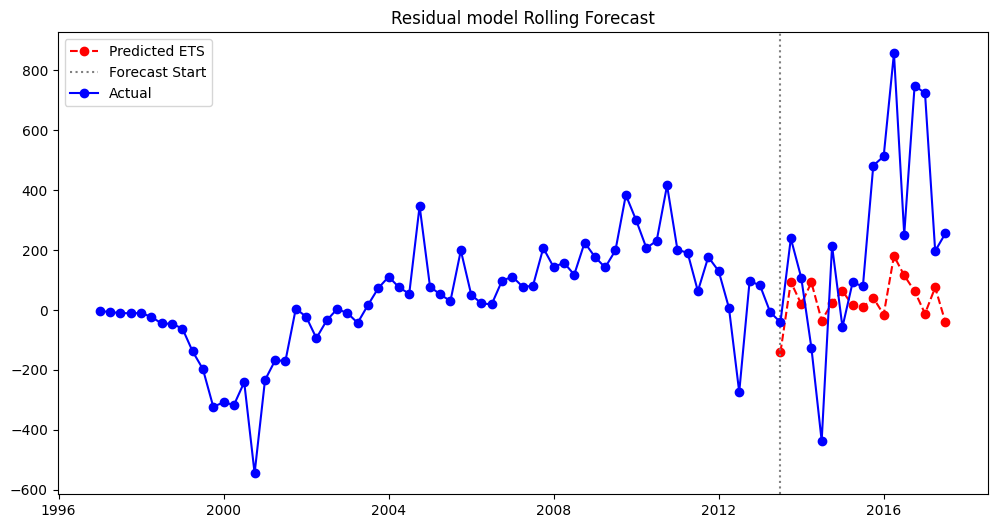

In [127]:
arima_model = ARIMA(train, order=optimized_orders['best_orders'][0]).fit()
arima_pred = arima_model.forecast(steps=len(test))

residuals = train - arima_model.fittedvalues

lags = 3
X_res = []
y_res = []

for i in range(lags, len(residuals)):
    X_res.append(residuals.values[i-lags:i])
    y_res.append(residuals.values[i])

X_res = np.array(X_res)
y_res = np.array(y_res)

res_model = XGBRegressor(n_estimators=5000, max_depth=3, random_state=42)
res_model.fit(X_res, y_res)

pred_residuals = []
history_res = list(residuals.values[-lags:])

for t in range(len(test)):
    X_test = np.array(history_res[-lags:]).reshape(1, -1)
    
    e_hat = res_model.predict(X_test)[0]
    pred_residuals.append(e_hat)
    
    history_res.append(e_hat)

final_forecast = arima_pred + np.array(pred_residuals)
evaluate_forecasts(test, final_forecast)

plt.figure(figsize=figsize)
plt.plot(test_ets.index, final_forecast, color='red', linestyle='--', label='Predicted',  marker='o')
plt.axvline(series.index[start_index], color='gray', linestyle=':', label='Forecast Start')
plt.plot(df["Net Income/Loss"], color = "blue", label="Actual", marker="o")

plt.legend()
plt.title("Residual model Rolling Forecast")
plt.show()

## Podsumowanie Modeli


In [123]:
import plotly.graph_objects as go
x_start = 0 
x_pred = list(range(x_start, x_start + len(predictions_prohpet)))  


fig = go.Figure()

fig.add_trace(go.Scatter(
    y=test,
    mode='lines',
    name='Actual Test',
    line=dict(color='black')
))

fig.add_trace(go.Scatter(
    y=predictions_prohpet.flatten(),
    mode='lines',
    name='Predicted Prophet',
    line=dict(color='blue', dash='dash')
))

colors = [
    "red", "blue", "green", "orange", "purple",
    "brown", "cyan", "magenta", "black", "gold"
]

for i in range(len(method)):
    fig.add_trace(go.Scatter(
        y=predictions[i]["forecast"],
        mode='lines',
        name=f'Predicted {method[i]}',
        line=dict(color=colors[i % len(colors)], dash='dash')
    ))


fig.add_trace(go.Scatter(
    y=pred_ets,
    mode='lines',
    name='Predicted ETS',
    line=dict(color='orange')
))



fig.update_layout(
    title="ARIMA vs Prophet",
    xaxis_title="Time Index",
    yaxis_title="Net Income/Loss",
    template="plotly_white",
    width=1200,  
    height=800    
)


fig.show()

In [124]:


models_metrics = {
    'Prophet': pr_metrics,
    'ARIMA': metrics_arima[0],
    'ARiMA Trend Removed': metrics_arima[1],
    'ARIMA Scaled': metrics_arima[2],
    "ARIMA Standard Scaling": metrics_arima[3],
    "ARIMA Quantile Scaling": metrics_arima[4],
    "ARIMA Ensemble": enseblme_metrics,
    "ARIMA Weighted Ensemble": weighted_enseblme_metrics,
    'ETS': ETS_metrics,
    "XGB": XGB_metrics
    
}




df_metrics = pd.DataFrame(models_metrics).T  
df_metrics = df_metrics.round(2)    

df_metrics.style.highlight_min(subset=['MAE','RMSE','SMAPE','MASE'], color='green')\
                .highlight_max(subset=['R^2'], color='green')



,MAE,RMSE,SMAPE,MASE,R^2
Prophet,242.030000,317.910000,93.610000,0.860000,0.060000
ARIMA,235.290000,285.990000,110.290000,0.860000,0.240000
ARiMA Trend Removed,233.630000,302.200000,100.930000,0.840000,0.150000
ARIMA Scaled,248.870000,291.290000,115.380000,0.900000,0.210000
ARIMA Standard Scaling,234.040000,285.710000,109.600000,0.860000,0.240000
ARIMA Quantile Scaling,231.770000,255.250000,112.200000,0.850000,0.400000
ARIMA Ensemble,236.460000,272.700000,111.010000,0.860000,0.310000
ARIMA Weighted Ensemble,238.320000,288.220000,106.420000,0.860000,0.230000
ETS,258.390000,305.870000,122.680000,0.960000,0.130000
XGB,263.910000,324.830000,111.830000,0.970000,0.020000


## Zadanie biznesowe

Implementacja modelu ariam do przewidywania okresów przyszłych


              Forecast    Lower_CI    Upper_CI  \
2017-09-30  561.300644  255.190454  867.410835   
2017-12-31  489.583843  146.314958  832.852728   
2018-03-31  363.551241  -24.855006  751.957488   
2018-06-30  236.088883 -199.227956  671.405722   

                                      Decision  
2017-09-30  Umiarkowana ekspansja / inwestycje  
2017-12-31       Utrzymanie bieżącej strategii  
2018-03-31       Utrzymanie bieżącej strategii  
2018-06-30       Utrzymanie bieżącej strategii  


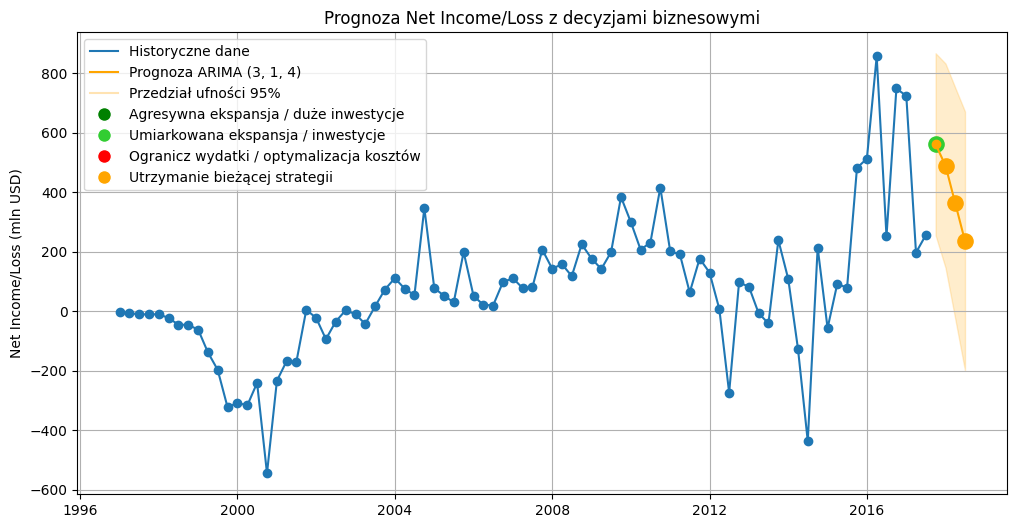

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


colors = {
    'Agresywna ekspansja / duże inwestycje': 'green',
    'Umiarkowana ekspansja / inwestycje': 'limegreen',
    'Ogranicz wydatki / optymalizacja kosztów': 'red',
    'Utrzymanie bieżącej strategii': 'orange'
}

df.index = pd.to_datetime(df.index)

series = df["Net Income/Loss"]

best_order = optimized_orders["best_orders"][0]   

model = ARIMA(series, order=best_order)
model_fit = model.fit()


forecast_steps = 4

forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

forecast_index = pd.date_range(
    start=series.index[-1] + pd.offsets.QuarterEnd(),
    periods=forecast_steps,
    freq='Q'
)

forecast_df = pd.DataFrame({
    "Forecast": forecast_mean.values,
    "Lower_CI": forecast_ci.iloc[:, 0].values,
    "Upper_CI": forecast_ci.iloc[:, 1].values
}, index=forecast_index)


def business_decision(row, level=500):
    if row["Lower_CI"] > level:
        return 'Agresywna ekspansja / duże inwestycje'
    
    elif row["Forecast"] > level:
        return 'Umiarkowana ekspansja / inwestycje'
    
    elif row["Forecast"] < level - 1000:
        return 'Ogranicz wydatki / optymalizacja kosztów'
    
    else:
        return 'Utrzymanie bieżącej strategii'

forecast_df["Decision"] = forecast_df.apply(business_decision, axis=1)

print(forecast_df)


plt.figure(figsize=(12, 6))

plt.plot(series.index, series.values, marker='o', label='Historyczne dane')

plt.plot(forecast_index, forecast_mean, marker='o', color='orange',
         label=f'Prognoza ARIMA {best_order}')

plt.fill_between(
    forecast_index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='orange',
    alpha=0.2,
    label='Przedział ufności 95%'
)

for date, row in forecast_df.iterrows():
    plt.scatter(date, row["Forecast"], color=colors[row["Decision"]], s=120)

decision_patches = [
    plt.Line2D([0], [0], marker='o', color='w',
               label=label, markerfacecolor=col, markersize=10)
    for label, col in colors.items()
]
plt.legend(handles=[
    plt.Line2D([], [], label='Historyczne dane'),
    plt.Line2D([], [], label=f'Prognoza ARIMA {best_order}', color='orange'),
    plt.Line2D([], [], label='Przedział ufności 95%', color='orange', alpha=0.3)
] + decision_patches, loc='upper left')

plt.title('Prognoza Net Income/Loss z decyzjami biznesowymi')
plt.ylabel('Net Income/Loss (mln USD)')
plt.grid(True)
plt.show()


Wykrywanie anomalii biznesowych za pomocą modelu arima

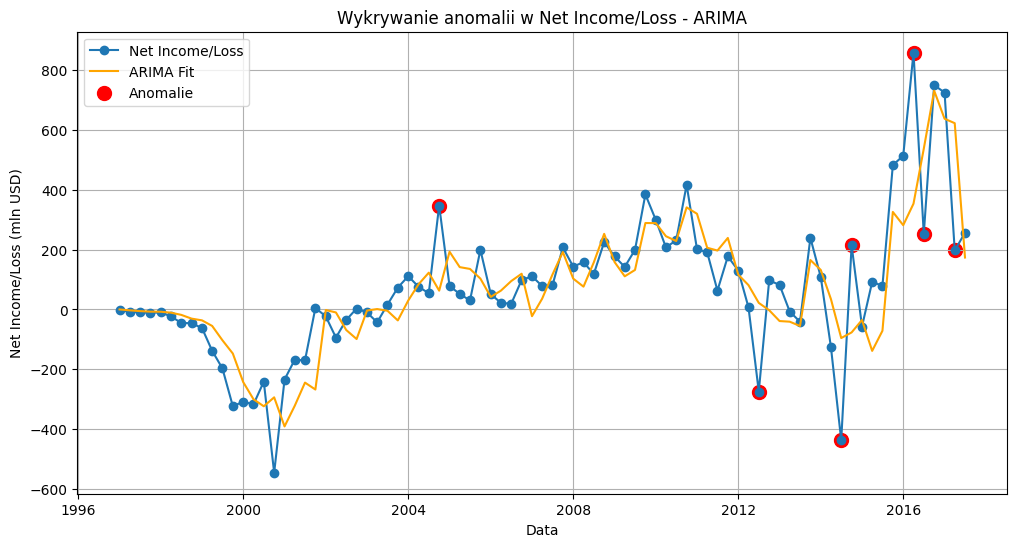

Wykryte anomalie:
            Net Income/Loss
Date                       
2004-10-01              347
2012-07-01             -274
2014-07-01             -437
2014-10-01              214
2016-04-01              857
2016-07-01              252
2017-04-01              197


In [126]:
fitted_values = model_fit.fittedvalues

residuals = df["Net Income/Loss"] - fitted_values


mean_resid = residuals.mean()
std_resid = residuals.std()
threshold_upper = mean_resid + 2*std_resid
threshold_lower = mean_resid - 2*std_resid

anomalies = df[(residuals > threshold_upper) | (residuals < threshold_lower)]

plt.figure(figsize=(12,6))
plt.plot(df.index, df["Net Income/Loss"], label='Net Income/Loss', marker='o')
plt.plot(df.index, fitted_values, label='ARIMA Fit', color='orange')
plt.scatter(anomalies.index, anomalies["Net Income/Loss"], color='red', s=100, label='Anomalie')
plt.title('Wykrywanie anomalii w Net Income/Loss - ARIMA')
plt.xlabel('Data')
plt.ylabel('Net Income/Loss (mln USD)')
plt.legend()
plt.grid(True)
plt.show()

print("Wykryte anomalie:")
print(anomalies)